# Diffusion maps with single sigma

* Modified from [Diffusion-Maps-in-Julia](https://github.com/chingruchung/Diffusion-Maps-in-Julia) by Ching-Ru Chung.
* Change package `PyPlot` to `Plots`
* Choose sigma as 25% in total distance

#### Author: Te-Sheng Lin, 2020

In [1]:
using LinearAlgebra
using MAT
using Plots
using Statistics

## 1. Read Data

Given a data set $X=\{x_1,...,x_n\} \in \mathbb{R}^d, \, d\ge 2$. 

Data stored in "Data.mat" with variable named "data".

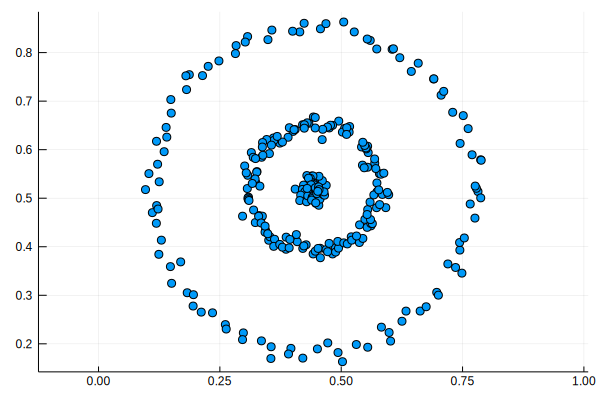

In [2]:
file = matread("Data.mat");
X = file["data"];

# Visualize the first two dimension of the data
scatter(X[:,1], X[:,2], aspect_ratio=:equal, leg=false)

## 1. Define a distance matrix $E$

Let $E$ be the square root of the Euclidean distance matrix ([EDM](https://en.wikipedia.org/wiki/Euclidean_distance_matrix)) with entries 

$$ E_{ij}=\| x_{i}-x_{j}\|_2 $$

In [3]:
# input: X - data points
# output: E - distance matrix
#
function get_E(X)
    n = size(X,1); # number of points
    E = zeros(n,n); # the diagonal entries are 0
    
    for ii=1:n
        for jj=ii+1:n
            E[ii,jj] = norm(X[ii,:] - X[jj,:]);
            E[jj,ii] = E[ii,jj];
        end
    end
    
    return E;
end

get_E (generic function with 1 method)

In [4]:
# get the distance matrix D
E = get_E(X);

## 2. Define a kernel matrix $K$

Let $K$ be a kernel matrix with entries $ K_{ij}=k(x_{i},x_{j}) $, where $k$ is the Guassian kernel
$$ k(x,y) = e^{-\frac{\lVert x-y \rVert^2}{\sigma^2}}, $$
and $\sigma$ is a constant chosen roughly as the $25\%$th smallest value of the distance matrix.

In [5]:
# evaluate sigma
E_sort = sort(E, dims=2);

n = size(X,1);
k = round(Int64, n/4);
sigma_loc = E_sort[:, k+1];
sigma = median(sigma_loc)

0.13538798665176516

In [6]:
# input 1: E - distance matrix
# input 2: sigma - constant
#
# output: K - kernal matrix
#
function get_K(E, sigma)
    K = exp.(-(E.^2) ./ (sigma^2));
    
    return K;
end

get_K (generic function with 1 method)

In [7]:
# get the kernal matrix K
K = get_K(E, sigma);

## 3. Construct a matrix $Q$ that related to diffusion matrix

Diffusion matrix, 
$$P=D^{-1}K,$$
where $D_{ii} = \sum^n_{j=1} K_{ij}$, is a matrix that describe the connectivity between two data points, which can be consider as the probability of jumping from one point to another in one step of random walk. 
Consider a matrix $Q$, 
$$ Q=D^{-\frac{1}{2}}KD^{-\frac{1}{2}},$$
it can be shown that the eigenvalues of $P$ and $Q$ are exactly the same, while the eigenvectors of $P$ are 
$$ v = D^{-1/2}v_Q,$$
where $v_Q$'s are the eigenvectors of $Q$.

In [8]:
# input: K - kernal matrix
#
# output 1: Q
# output 2: d_sq - sqrt{D}
#
function get_Q(K)
    n = size(K,1);
    Q = zeros(n,n);
    d_sq = zeros(n);
    
    # d_sq = sqrt{D}
    for ii = 1:n
        d_sq[ii] = sqrt(sum(K[ii,:]));
    end
    
    # get components of Q
    for ii = 1:n
        for jj = 1:n
            Q[ii,jj] = K[ii,jj]/(d_sq[ii]*d_sq[jj]);
        end
    end
    
    return Q, d_sq;
end

get_Q (generic function with 1 method)

In [9]:
# get Q and d_sq
Q, d_sq = get_Q(K);

## 4. Find eigenvectors and eigenvalues of the diffusion matrix

As we mention earlier,
>the eigenvalues of $P$ and $Q$ are exactly the same, while the eigenvectors of $P$ are 
$$ v = D^{-1/2}v_Q,$$ where $v_Q$'s are the eigenvectors of $Q$.

In [10]:
# input 1: Q
# input 2: d_sq - sqrt{D}
#
# output 1: v - eigenvectors
# output 2: s - eigenvalues
#
function get_eig(Q, d_sq)
    
    n = size(Q, 1);
    
    U,S,V = svd(Q); # U and S contains eigenvectors and eigenvalues repectively 
                    # which is arranged in descending power. 

    v = zeros(n,n);

     for ii = 1 : n
        V[ii,:] = V[ii,:]/d_sq[ii];
    end


    for ii = 1 : n
        v[:,ii] = V[:,ii]/norm(V[:,ii]);
    end
    
    return v, S;
end

get_eig (generic function with 1 method)

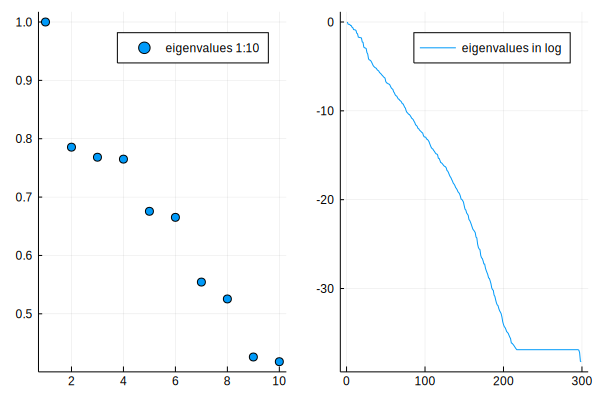

In [11]:
c = 3 ; # the desired reduced dimension

v, s = get_eig(Q , d_sq);
p1 = scatter(s[1:10], label="eigenvalues 1:10");
p2 = plot(log.(s), label="eigenvalues in log");
plot(p1, p2, layout=2)

## 4. Define a diffusion map 

Let $Y$ be a diffusion map, which map corrdinates between data and diffusion space, with its column
$$Y_i=
\begin{bmatrix}
p_t(x_i,x_1) \\
p_t(x_i,x_2) \\
\vdots       \\
p_t(x_i,x_n) \\
\end{bmatrix}
= \left[ \lambda_i^t v_i \right] = P_{i}^t.$$

In [12]:
function get_Y(v, S, c)
    
    n = size(v,1);
    Y = zeros(n,c);
    
    # get components of diffusion map Y
    for ii = 1:c
        Y[:,ii] = v[:,ii+1].*S[ii+1];
    end
    
    return Y ;
end

get_Y (generic function with 1 method)

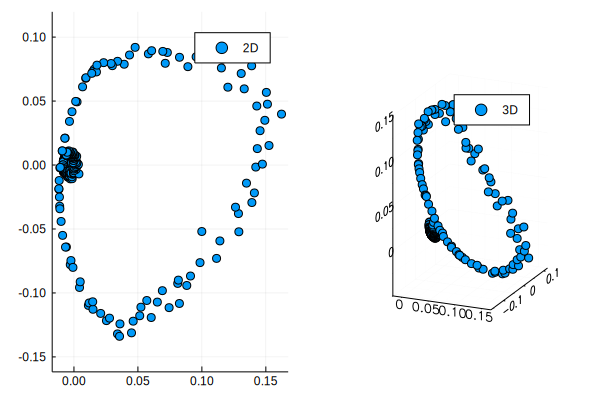

In [13]:
Y = get_Y(v, s, c);

# print diffution map
p1 = scatter(Y[:,1], Y[:,2], label="2D", aspect_ratio=:equal)
p2 = scatter(Y[:,1], Y[:,2], Y[:,3], label="3D", aspect_ratio=:equal)
plot(p1, p2, layout=2)

### 5. K-means Clustering

Using k-means method to get the labeling of the datas, here k is a manually select number of groups.

In [14]:
function k_means(Y , cluster) # cluster is the number of groups
    
    n = size(Y,1) ;
    d = size(Y,2) ;
    center = zeros(cluster,d) ;
    
    index = rand(1:n , cluster) ; # Randomly pick the same number of numbers as cluster from 1~n
    group , weight1 = classify(Y , Y[index , :]) ; # find the first weight
    
    center = update_center(Y , group , cluster) ;  # update the center
    group , weight2 = classify(Y , center) ;       # find the next weight
    
    # classify and update repeatly until the weight becomes stabilize.
    time = 1 ;
    while weight1 != weight2
        # replace as previos one
        weight1 = weight2 ;
        
        # update and classify to get a new groups
        center  = update_center(Y , group , cluster) ;
        group , weight2 = classify(Y , center) ;
        
        time += 1 ;
    end
    
    print("The update times = ", time) ; # print the number of executions of while loop.
    
    return group , center ;
end

k_means (generic function with 1 method)

classify function is to classify the points into three groups by comparing the distances between the point and three centers respectively.

In [15]:
function classify(Y , center)
    
    n = size(Y,1) ;
    cluster = size(center,1) ; # number of center
    weight = 0 ;
    group = ones(n) ; # Classify the n points by label as 1 ~ cluster.
    
    for ii = 1 : n
        
        # For all points in Y , find the minimum of distances with centers.
        DistanceMin = sum((Y[ii,:] - center[1,:]).^2) ;
        for jj = 2 : cluster
            
            # Strictly speaking , it is the square of the distance
            distance = sum((Y[ii,:] - center[jj,:]).^2) ;
            
            # If the point is closer to one center than the others,
            # then it will be put in the group belong to the center.
            if DistanceMin > distance
                DistanceMin = distance ;
                group[ii] = jj ;
            end
            
        end
        
        # get weight by summing up all distance between point and center in same group.
        weight += DistanceMin ;
        
    end
    
    return group , weight ;
end

classify (generic function with 1 method)

update_center function is to reset the centers by finding the centroids from each group.

In [16]:
function update_center(Y , group , cluster)
    n = size(Y,1) ;
    d = size(Y,2) ;
    center = zeros(cluster,d) ;
    num = zeros(cluster) ;
    
    # find new centroids (or geometric center) from each group.
    for ii = 1 : n
        center[Int(group[ii]) , :] += Y[ii,:] ;
        num[Int(group[ii])] += 1 ;
    end
    
    for ii = 1 : cluster
        center[ii,:] ./= num[ii] ;
    end
    
    return center
end

update_center (generic function with 1 method)

### 3. Use k-means clustering

In [17]:
# it will return the label of points and tell us how many times the center was updated.
cluster = 3 ; # seperate into three groups
group, center = k_means(Y , cluster) ;

The update times = 4

### 4. Show the result

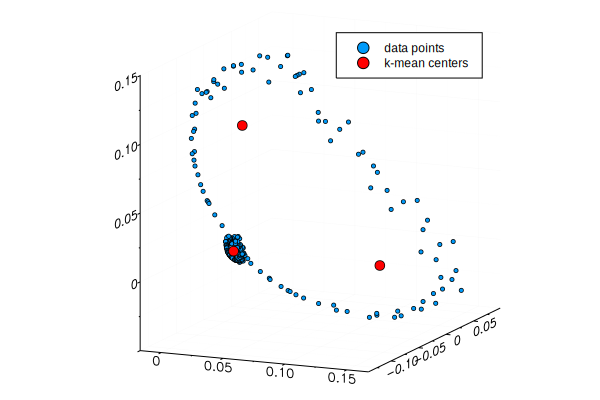

In [18]:
scatter(Y[:,1] , Y[:,2] , Y[:,3], markersize=:2, label="data points")
scatter!(center[:,1] , center[:,2] , center[:,3], markercolor=:red, markersize=:5, label="k-mean centers")

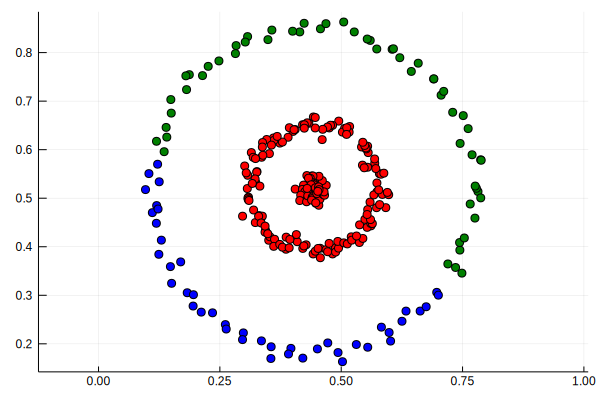

In [19]:
# select the color
dict = Dict(1 => "red" , 2 => "green" , 3 => "blue" , 4 => "black" , 5 => "brown" , 6 => "cyan" , 7 => "orange") ;
color_group = Array{String}(undef, size(group , 1));
for ii = 1 : size(group , 1)
    color_group[ii] = dict[group[ii]];
end

# print
scatter(X[:,1] , X[:,2], c = color_group, leg=false, aspect_ratio=:equal)